# IMPORT LIBRARIES AND DATASETS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import random
from glob import glob
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications import DenseNet121, DenseNet169
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
%matplotlib inline
# create a image generator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')

In [3]:
  brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [4]:
brain_df.head(10)

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   
5  TCGA_CS_5395            2.0                 4.0             2        2.0   
6  TCGA_CS_5396            3.0                 3.0             2        3.0   
7  TCGA_CS_5397            NaN                 4.0             1        2.0   
8  TCGA_CS_6186            2.0                 4.0             1        2.0   
9  TCGA_CS_6188            2.0                 4.0             3        2.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   
5          NaN              3.0           2                3.0   
6          2.0              2.0           3                3.0   
7          3.0              3.0           2                1.0   
8          1.0              3.0           2                2.0   
9          3.0              3.0           2                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   
5                        1.0                1.0         3.0             5.0   
6                        2.0                1.0         3.0             2.0   
7                        2.0                1.0         1.0             6.0   
8                        2.0                1.0         3.0             2.0   
9                        2.0                1.0         3.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0  
5     2.0                       43.0   2.0        NaN      1.0  
6     1.0                       53.0   3.0        2.0      0.0  
7     1.0                       54.0   3.0        2.0      1.0  
8     2.0                       58.0   3.0        2.0      1.0  
9     2.0                       48.0   3.0        2.0      0.0

In [5]:
data_map = []
for sub_dir_path in glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [6]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

patient_id                                               path
0  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4  TCGA_DU_7010_19860307  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

In [7]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_15.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_15_mask.tif


In [8]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
'''pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 50)'''
brain_df



patient_id  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                                                                           image_path  \
0      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif   
1      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif   
2      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif   
3      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif   
4      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif   
...                                                                                               ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86.tif   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87.tif   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87.tif   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88.tif   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88.tif   

                                                                                                 mask_path  \
0      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif   
1      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif   
2      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif   
3      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif   
4      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif   
...                                                                                                    ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86_mask.tif   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87_mask.tif   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87_mask.tif   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88_mask.tif   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88_mask.tif   

      mask  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
3924     0  
3925     0  
3926     0  
3927     0  
3928     0  

[3929 rows x 4 columns]

#  PERFORM DATA VISUALIZATION

In [9]:
brain_df

patient_id  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                                                                           image_path  \
0      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif   
1      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif   
2      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif   
3      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif   
4      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif   
...                                                                                               ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86.tif   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87.tif   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87.tif   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88.tif   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88.tif   

                                                                                                 mask_path  \
0      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif   
1      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif   
2      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif   
3      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif   
4      /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif   
...                                                                                                    ...   
3924  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86_mask.tif   
3925  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87_mask.tif   
3926  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87_mask.tif   
3927  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88_mask.tif   
3928  /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88_mask.tif   

      mask  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
3924     0  
3925     0  
3926     0  
3927     0  
3928     0  

[3929 rows x 4 columns]

In [10]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

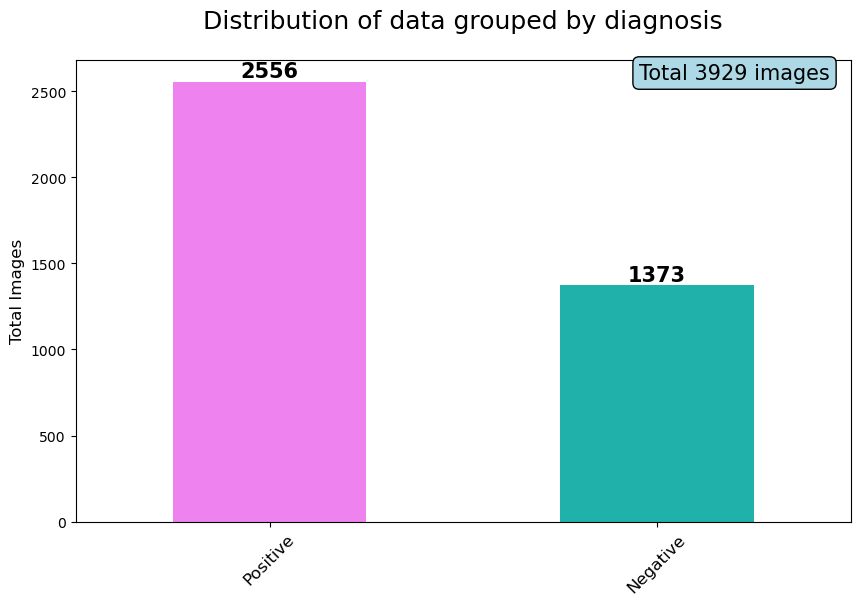

In [11]:
# Plot
ax = brain_df['mask'].value_counts().plot(kind='bar',
                                          stacked=True,
                                          figsize=(10, 6),
                                          color=["violet", "lightseagreen"])

ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12)
ax.set_ylabel('Total Images', fontsize=12)
ax.set_title("Distribution of data grouped by diagnosis", fontsize=18, y=1.05)

# Annotate
for i, rows in enumerate(brain_df['mask'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows), 
                rotation=0, color="black", 
                ha="center", va="bottom", 
                fontsize=15, fontweight="bold")

ax.text(1.2, max(brain_df['mask'].value_counts().values) + 50, f"Total {len(brain_df)} images", size=15,
        color="black",
        ha="center", va="center",
        bbox=dict(boxstyle="round",
                  fc=("lightblue"),
                  ec=("black")))

plt.show()

In [12]:
brain_df.mask_path

0        /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif
1        /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1_mask.tif
2        /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif
3        /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1_mask.tif
4        /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1_mask.tif
                                                        ...                                                 
3924    /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86_mask.tif
3925    /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87_mask.tif
3926    /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87_mask.tif
3927    /kaggle/inp

In [13]:
brain_df.image_path

0        /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif
1        /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8162_19961029/TCGA_DU_8162_19961029_1.tif
2        /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif
3        /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_1.tif
4        /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif
                                                     ...                                               
3924    /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86.tif
3925    /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87.tif
3926    /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87.tif
3927    /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61

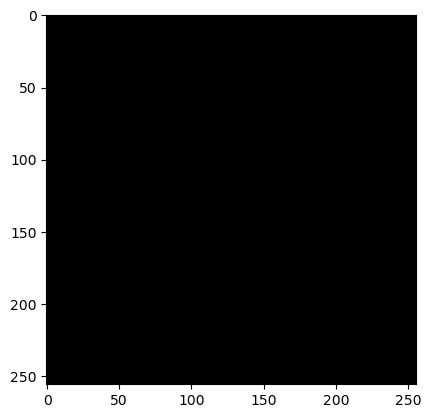

In [14]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

In [15]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [16]:
cv2.imread(brain_df.mask_path[623]).max()

0

In [17]:
cv2.imread(brain_df.mask_path[623]).min()

0

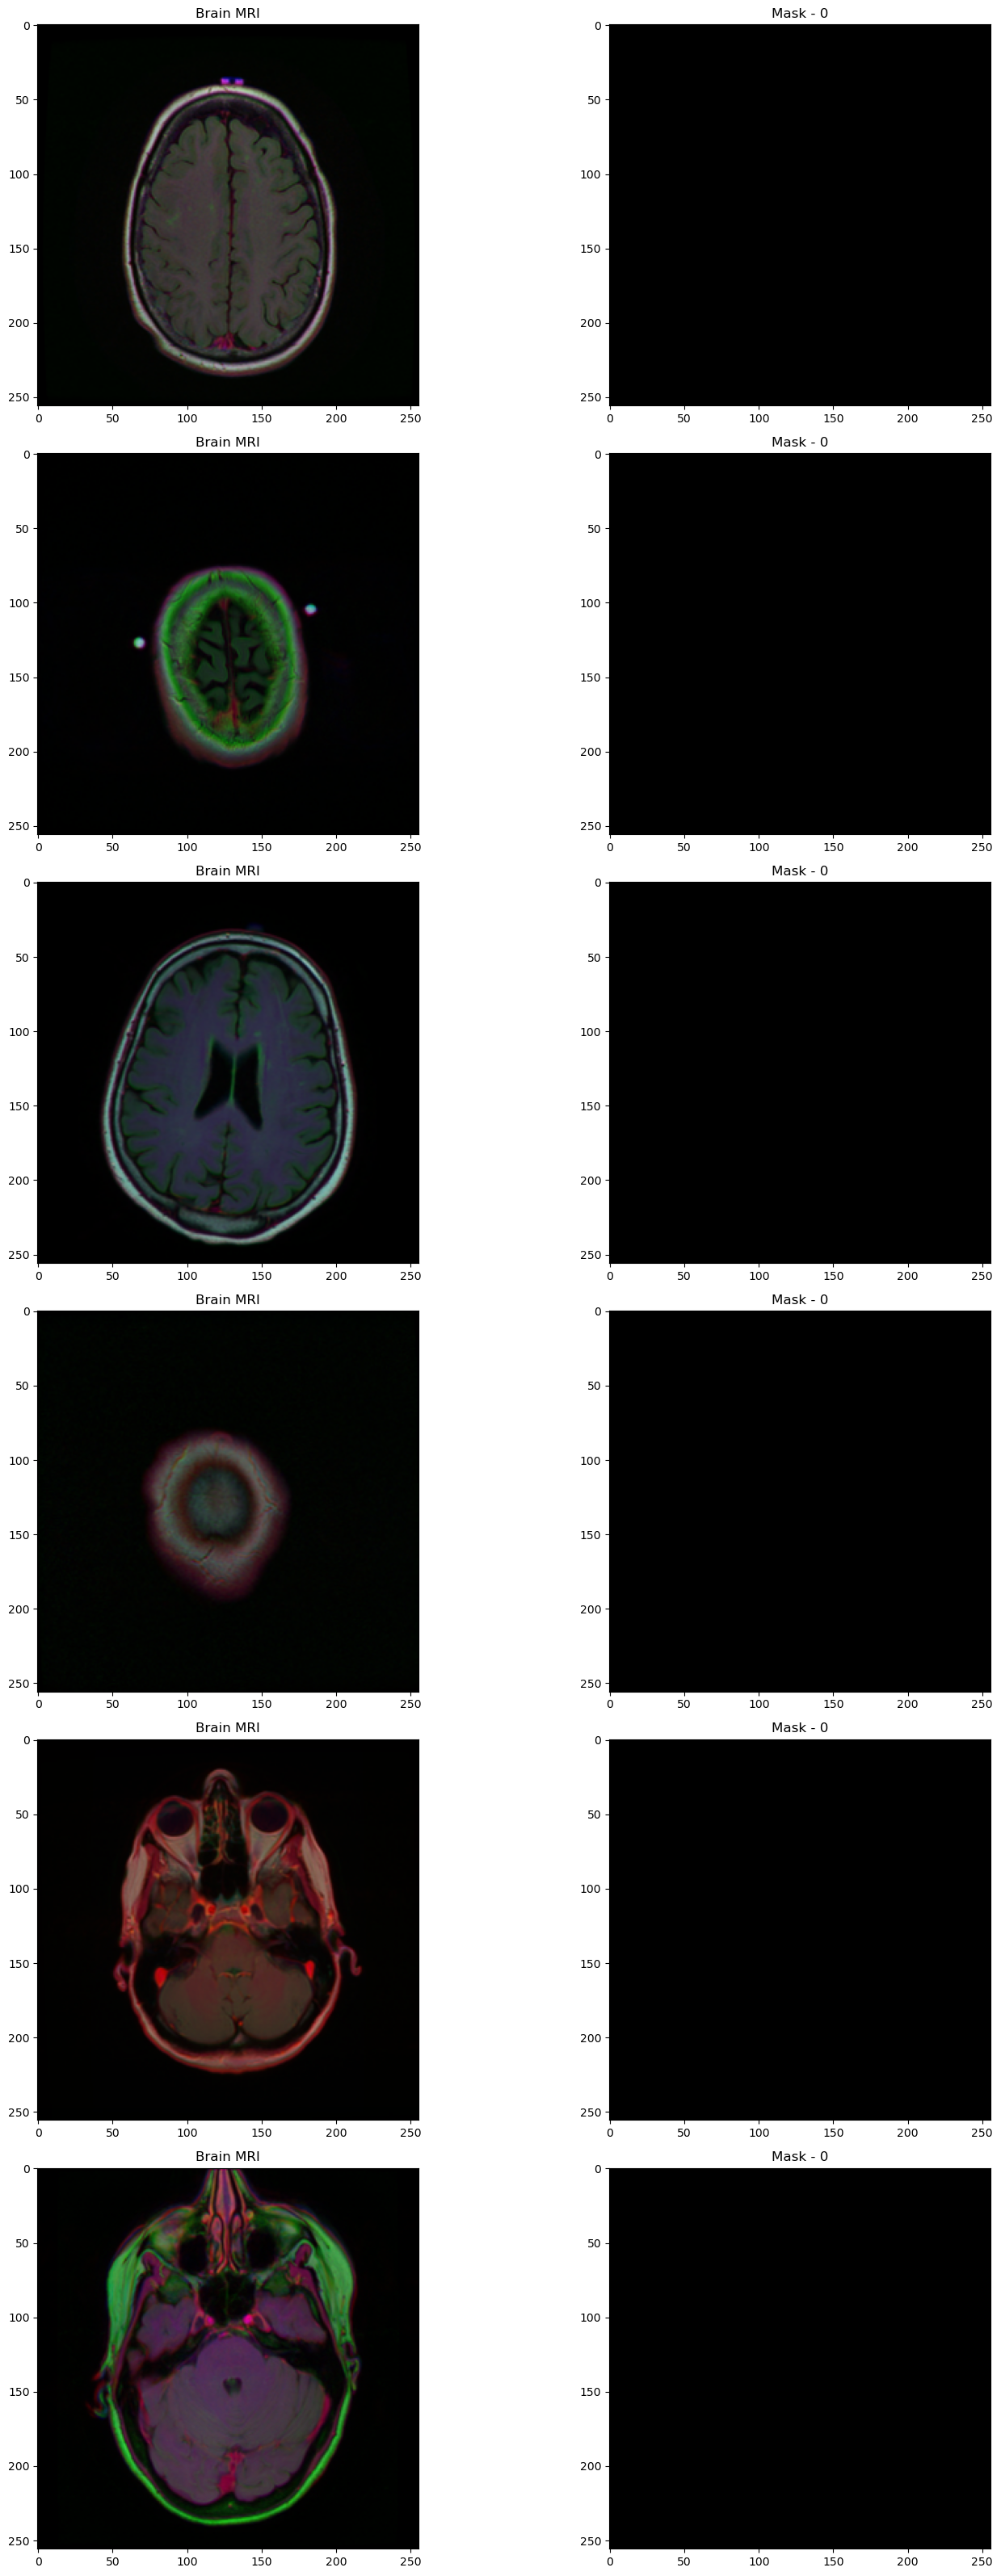

In [18]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
    i = random.randint(0, len(brain_df)) # select a random index
    axs[count][0].title.set_text("Brain MRI") # set title
    axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
    axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
    axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
    count += 1

fig.tight_layout()

In [19]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
    if brain_df['mask'][i] ==1 and count <12:
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text('Brain MRI')
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text('Mask')
        axs[count][1].imshow(mask, cmap = 'gray')


        img[mask == 255] = (255, 0, 0)
        axs[count][2].title.set_text('MRI with Mask')
        axs[count][2].imshow(img)
        count+=1

fig.tight_layout()


# Phân loại

In [20]:
# Drop the patient id column
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [21]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
# You will get this error message if you comment out the following code line:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [22]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [23]:
batch_size = 16
epochs = 100
image_size = 256

In [24]:
# split the data into train and test data
train, test = train_test_split(brain_df_train, test_size = 0.2)
# create a image generator
# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
train_datagen  = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.3,
    rotation_range=20,            # Rotate images by 20 degrees
    width_shift_range=0.1,        # Randomly shift images horizontally by 10% of the width
    height_shift_range=0.1,       # Randomly shift images vertically by 10% of the height
    zoom_range=0.2,               # Apply random zooming in the range of 0.8 to 1.2
    horizontal_flip=True         # Flip images horizontally
)
     

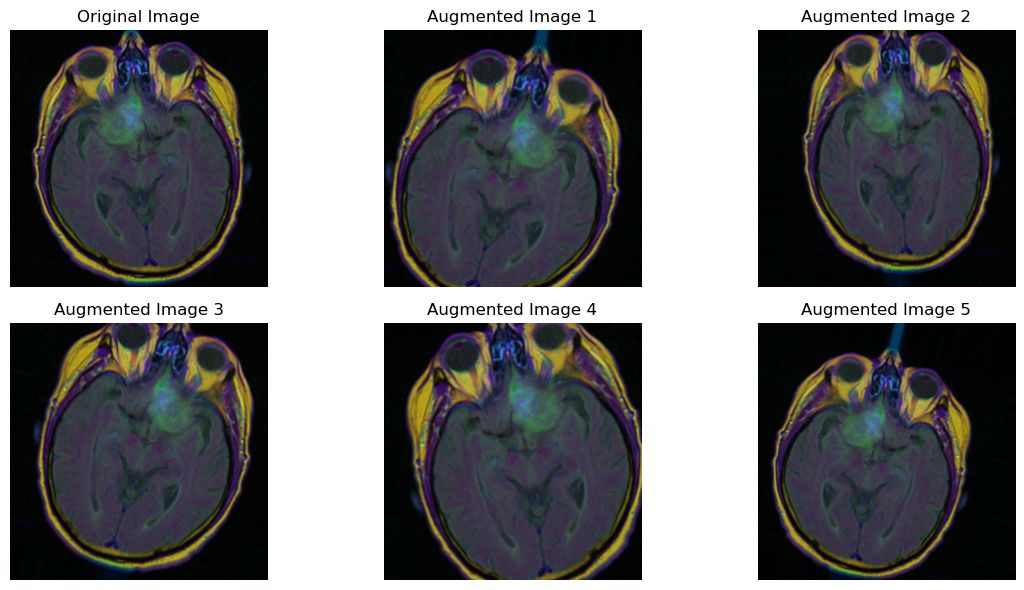

In [25]:
# Đường dẫn tới hình ảnh
image_path = '../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif'

# Đọc hình ảnh ban đầu
image = plt.imread(image_path)

# Số lượng phiên bản mới muốn tạo ra
num_augmented_images = 5

# Tạo ra các phiên bản biến đổi của hình ảnh
augmented_images = []
for _ in range(num_augmented_images):
    augmented_image = train_datagen.random_transform(image)
    augmented_images.append(augmented_image)

# Hiển thị hình ảnh ban đầu và các phiên bản mới
plt.figure(figsize=(12, 6))

# Hình ảnh ban đầu
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Các phiên bản mới
for i in range(num_augmented_images):
    plt.subplot(2, 3, i + 2)
    plt.imshow(augmented_images[i])
    plt.title(f'Augmented Image {i + 1}')
    plt.axis('off')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [26]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=batch_size,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=batch_size,
shuffle=False,
class_mode='categorical',
target_size=(256,256))



Found 2201 validated image filenames belonging to 2 classes.
Found 942 validated image filenames belonging to 2 classes.
Found 786 validated image filenames belonging to 2 classes.


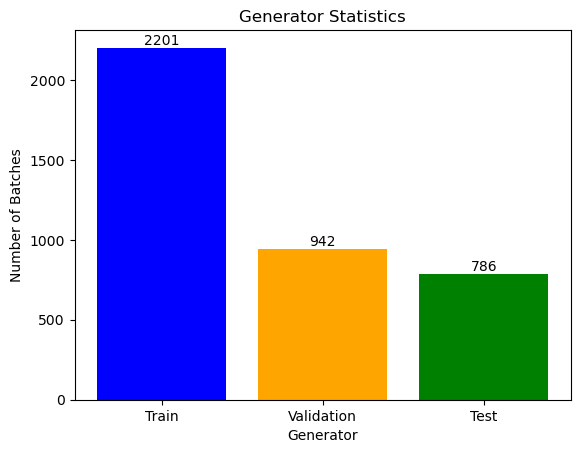

In [27]:
# Calculate the number of batches in each generator
train_steps = train_generator.n
valid_steps = valid_generator.n
test_steps = test_generator.n

# Create a list of labels for the x-axis
labels = ['Train', 'Validation', 'Test']

# Create a list of values for the y-axis
values = [train_steps, valid_steps, test_steps]

# Define the colors for each bar
colors = ['blue', 'orange', 'green']

# Plot the bar chart
plt.bar(labels, values, color=colors)
plt.xlabel('Generator')
plt.ylabel('Number of Batches')
plt.title('Generator Statistics')

# Add the numbers on top of the bars
for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.show()


# ResNet50

94765736/94765736 [==============================] - 0s 0us/step


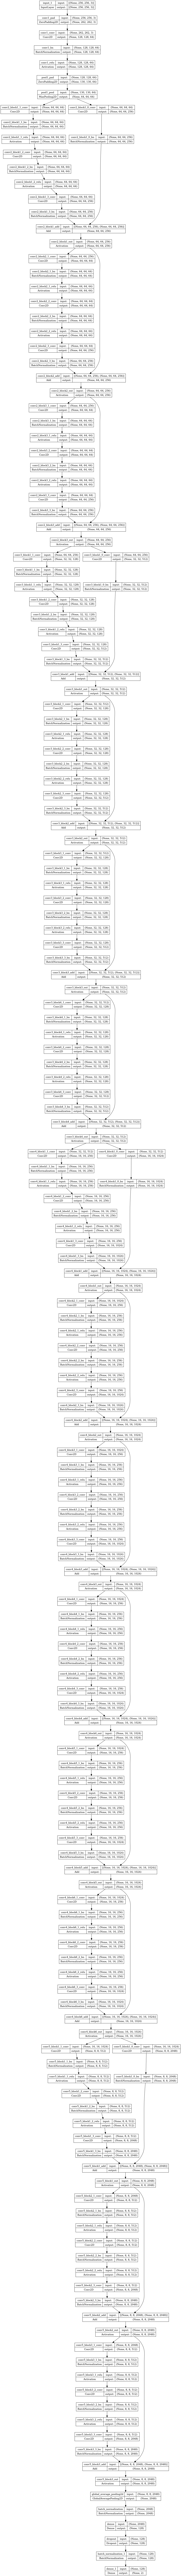

In [28]:
num_classes = 2
adam = tf.keras.optimizers.Adam(lr=0.001)


# create the base pre-trained model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

# Add a fully-connected layer and dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# Thêm lớp Fully-Connected và Dropout
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
# Add a logistic layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model_ResNet50 = Model(inputs=base_model.input, outputs=predictions)
display(tf.keras.utils.plot_model(model_ResNet50, to_file='model_ResNet50.png', show_shapes=True))


# compile the model (should be done *after* setting layers to non-trainable)
model_ResNet50.compile(optimizer="Adam", loss='categorical_crossentropy',metrics=['accuracy'])


checkpoint_filepath_transfer_ResNet50 = 'model_resnet50.hdf5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath_transfer_ResNet50, monitor='val_loss',mode='auto',save_best_only=True)
# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)


In [29]:
model_ResNet50.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [30]:
start_time = time.time()
history_ResNet50 = model_ResNet50.fit(
                    train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=epochs,
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator),
                    callbacks=[mc, es, reduce_lr]
                )
end_time = time.time()
ResNet50_time = end_time-start_time

Epoch 1/100
138/138 [==============================] - 121s 538ms/step - loss: 0.7672 - accuracy: 0.6656 - val_loss: 0.6919 - val_accuracy: 0.5998 - lr: 0.0010
Epoch 2/100
138/138 [==============================] - 57s 415ms/step - loss: 0.6854 - accuracy: 0.6801 - val_loss: 0.6636 - val_accuracy: 0.6624 - lr: 0.0010
Epoch 3/100
138/138 [==============================] - 55s 402ms/step - loss: 0.5553 - accuracy: 0.7301 - val_loss: 1.6391 - val_accuracy: 0.3376 - lr: 0.0010
Epoch 4/100
138/138 [==============================] - 55s 401ms/step - loss: 0.5555 - accuracy: 0.7247 - val_loss: 3.4364 - val_accuracy: 0.3376 - lr: 0.0010
Epoch 5/100
138/138 [==============================] - 54s 390ms/step - loss: 0.5002 - accuracy: 0.7333 - val_loss: 3.0298 - val_accuracy: 0.3376 - lr: 0.0010
Epoch 6/100
138/138 [==============================] - 55s 401ms/step - loss: 0.5115 - accuracy: 0.7497 - val_loss: 0.6454 - val_accuracy: 0.6104 - lr: 0.0010
Epoch 7/100
138/138 [========================

In [31]:
history_ResNet50.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [32]:
ResNet50_time

6954.543863296509

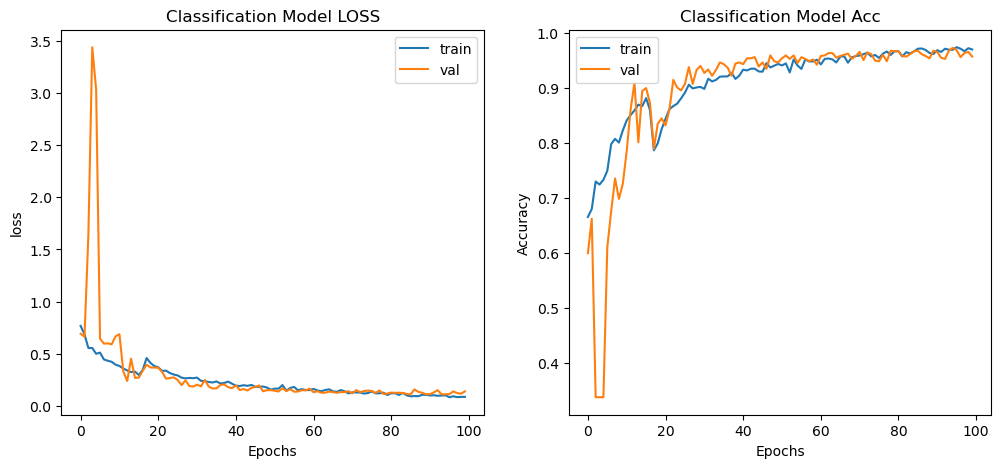

In [33]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_ResNet50.history['loss']);
plt.plot(history_ResNet50.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history_ResNet50.history['accuracy']);
plt.plot(history_ResNet50.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [34]:
loss_ResNet50,acc_ResNet50 = model_ResNet50.evaluate(test_generator)
print("%s: %.4f" % ("Evaluate Test Loss", loss_ResNet50))
print("%s: %.4f" % ("Evaluate Test accuracy", acc_ResNet50))

50/50 [==============================] - 7s 133ms/step - loss: 0.1115 - accuracy: 0.9656
Evaluate Test Loss: 0.1115
Evaluate Test accuracy: 0.9656


50/50 [==============================] - 3s 45ms/step
0.9656488549618321
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       488
           1       0.96      0.95      0.95       298

    accuracy                           0.97       786
   macro avg       0.96      0.96      0.96       786
weighted avg       0.97      0.97      0.97       786



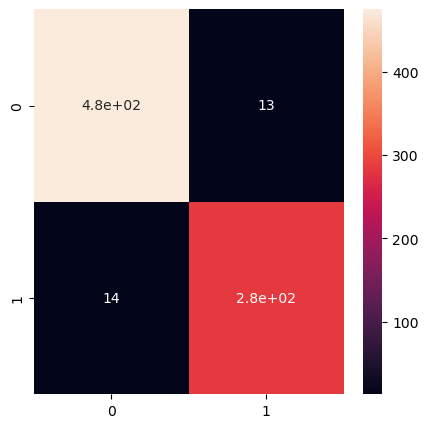

In [35]:
prediction = model_ResNet50.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);



1/1 [==============================] - 1s 1s/step
Predictions: [[9.996406e-01 3.594290e-04]]
Độ chính xác: (99.964 %)
Dự đoán: Not Tumor
ResNet50 Prediction


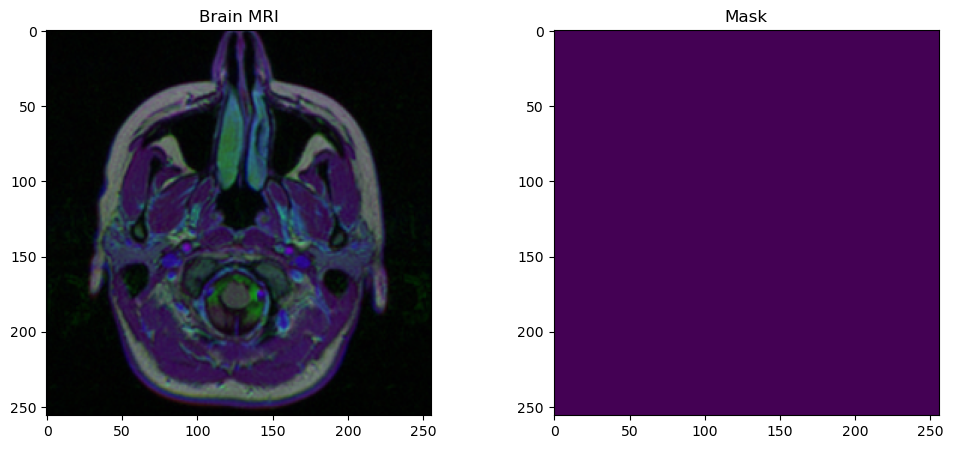

1/1 [==============================] - 0s 24ms/step
Predictions: [[5.203925e-04 9.994796e-01]]
Độ chính xác: (99.948 %)
Dự đoán: Tumor
ResNet50 Prediction


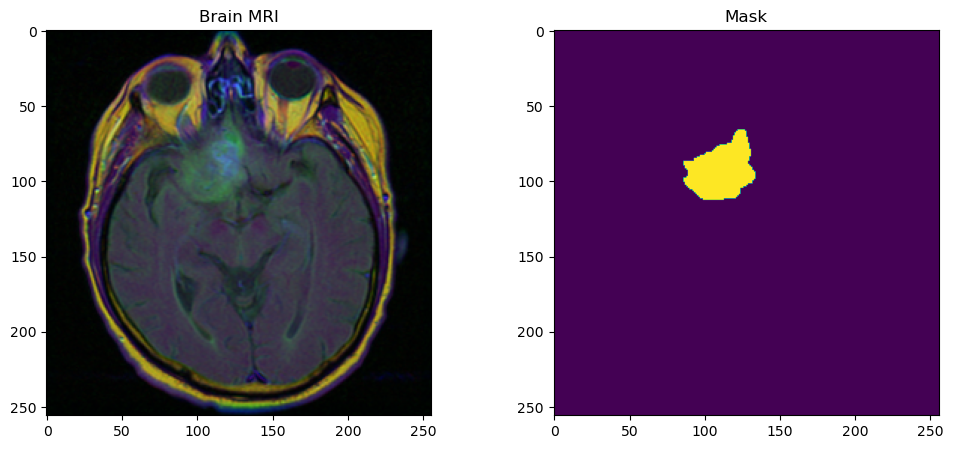

In [36]:
image=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1.tif')
image=cv2.resize(image,dsize=(256,256))
image=image /255.0
image_ex=np.expand_dims(image,axis=0)
image_mask=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_1_mask.tif')

classes={0:'Not Tumor', 1:'Tumor'}
# Make prediction
prediction = model_ResNet50.predict(image_ex)

decoded_predictions = [classes[i] for i in np.argmax(prediction, axis=1)]
titDudoan = decoded_predictions[0]
xacsuat = max(prediction[0])*100
# In kết quả
print('Predictions:', prediction)
print('Độ chính xác: ({:.3f} %)'.format(xacsuat))
print('Dự đoán: {}'.format(titDudoan))
print('ResNet50 Prediction')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Brain MRI");
plt.subplot(1,2,2)
plt.imshow(image_mask)
plt.title("Mask");
plt.show()
print("===========================================================================================================")

image=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif')
image=cv2.resize(image,dsize=(256,256))
image=image /255.0
image_ex=np.expand_dims(image,axis=0)
image_mask=plt.imread('../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif')

classes={0:'Not Tumor', 1:'Tumor'}
# Make prediction
prediction = model_ResNet50.predict(image_ex)

decoded_predictions = [classes[i] for i in np.argmax(prediction, axis=1)]
titDudoan = decoded_predictions[0]
xacsuat = max(prediction[0])*100
# In kết quả
print('Predictions:', prediction)
print('Độ chính xác: ({:.3f} %)'.format(xacsuat))
print('Dự đoán: {}'.format(titDudoan))
print('ResNet50 Prediction')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Brain MRI");
plt.subplot(1,2,2)
plt.imshow(image_mask)
plt.title("Mask");
plt.show()